# VOOM-SNM normalization

### read in metadata and raw data

In [6]:
require(ggplot2)
require(snm)
require(limma)
require(edgeR)
require(dplyr)
require(edgeR)
require(pvca)
require(lme4)
require(doMC)
require(parallel)

numCores <- detectCores()
registerDoMC(cores=numCores)

#read in data
tmp <- as.data.frame(read.csv("data/Kraken-TCGA-Raw-Data-All-18116-Samples.csv", header = TRUE, sep = ",", dec = ".",stringsAsFactors=FALSE))
row.names(tmp) <- tmp[,1]
tmp<-tmp[,-1]
vbDataBarnDFReconciled<-tmp
#vbDataBarnDFReconciled[1:5,]

tmp <- as.data.frame(read.csv("data/Kraken-TCGA-Raw-Data-17625-Samples.csv", header = TRUE, sep = ",", dec = ".",stringsAsFactors=FALSE))
row.names(tmp) <- tmp[,1]
tmp<-tmp[,-1]
vbDataBarnDFReconciledQC<-tmp
#vbDataBarnDFReconciledQC[1:2,]


tmp <- as.data.frame(read.csv("data/Metadata-TCGA-Kraken-17625-Samples.csv", header = TRUE, sep = ",", dec = ".",stringsAsFactors=FALSE))
row.names(tmp) <- tmp[,1]
tmp<-tmp[,-1]
metadataSamplesAllQC<-tmp
#metadataSamplesAllQC[1:2,]

print(dim(vbDataBarnDFReconciled))
print(dim(vbDataBarnDFReconciledQC))
print(dim(metadataSamplesAllQC))

save(vbDataBarnDFReconciledQC,vbDataBarnDFReconciled,metadataSamplesAllQC, file = "data/tcgaVbDataAndMetadataAndSNM.RData")


Loading required package: ggplot2

Loading required package: snm

Loading required package: limma

Loading required package: edgeR

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: pvca

Loading required package: lme4

Loading required package: Matrix

Loading required package: doMC

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



[1] 18116  1993
[1] 17625  1993
[1] 17625    41


In [1]:
#load("data/validationSplitVbDataAndMetadata.RData")

### filter missing data

In [7]:
tmp <- as.data.frame(read.csv("data/Metadata-TCGA-All-18116-Samples.csv", header = TRUE, sep = ",", dec = ".",stringsAsFactors=FALSE))
row.names(tmp) <- tmp[,1]
tmp<-tmp[,-1]
metadataSamplesAll<-tmp


metadataSamplesAllQCAML <- droplevels(metadataSamplesAll[! (is.na(metadataSamplesAll$race) | 
                                                           is.na(metadataSamplesAll$portion_is_ffpe) |
                                                           is.na(metadataSamplesAll$age_at_diagnosis)),])
# metadataSamplesAllQCAML <- droplevels(metadataSamplesAllQCAML[metadataSamplesAllQCAML$disease_type == "Acute Myeloid Leukemia",])
vbDataBarnDFReconciledQCAML <- vbDataBarnDFReconciled[rownames(metadataSamplesAllQCAML),]

print(dim(metadataSamplesAllQCAML))
print(dim(vbDataBarnDFReconciledQCAML))

[1] 17975    41
[1] 17975  1993


### voom process
Voom was published in Genome Biology and has been cited >2000 times for transforming discrete count data into microarray-like data, such that tools originally developed for microarrays (e.g. limma) can be used on the transformed data.

Do note that errors were flagged based on some metadata columns, so entries were concatenated/cleaned up using gsub (as shown in the script)

[1] "Now normalizing data..."
[1] "Now applying voom on normalized data..."

                       Additional - New Primary 
                                             10 
                          Additional Metastatic 
                                              1 
                           Blood Derived Normal 
                                           1866 
                                     Metastatic 
                                            541 
Primary Blood Derived Cancer - Peripheral Blood 
                                            258 
                                  Primary Tumor 
                                          13898 
                                Recurrent Tumor 
                                            118 
                            Solid Tissue Normal 
                                           1283 
[1] 17625   205
[1] 17625     7
[1] 17625     2
[1] 17625  1795
[1] 17625   211


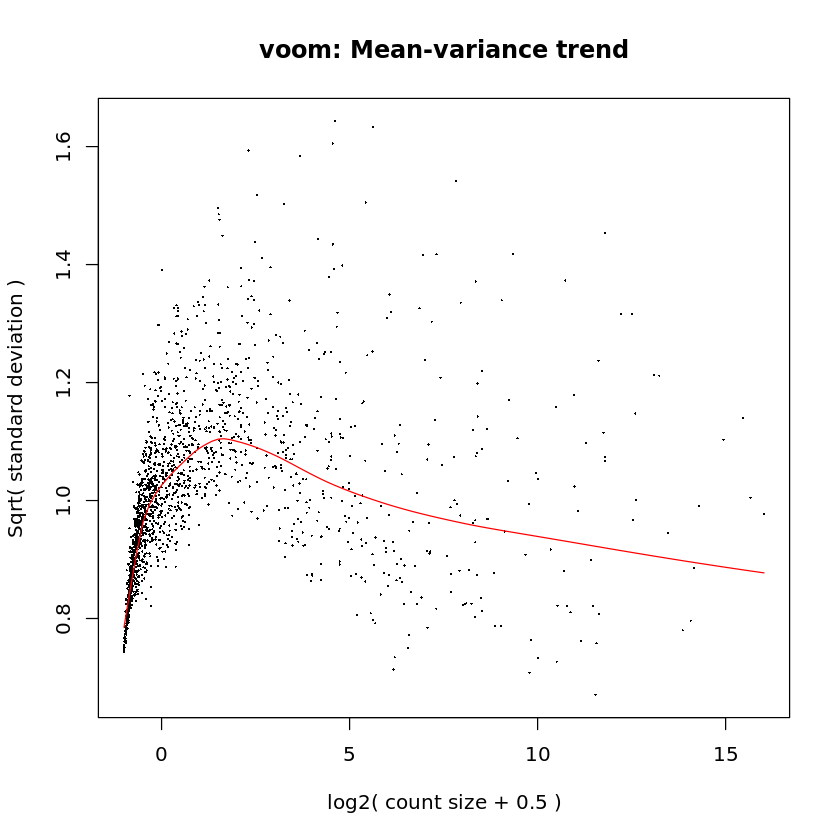

In [8]:
qcMetadata <- metadataSamplesAllQC # metadataSamplesAllQCAML
qcData <- vbDataBarnDFReconciledQC # vbDataBarnDFReconciledQCAML

# Set up design matrix
covDesignNorm <- model.matrix(~0 + sample_type +
                                  data_submitting_center_label +
                                  platform +
                                  experimental_strategy +
                                  tissue_source_site_label +
                                  portion_is_ffpe,
                              data = qcMetadata)
#print(colnames(covDesignNorm))
colnames(covDesignNorm) <- gsub('([[:punct:]])|\\s+','',colnames(covDesignNorm))
#print(colnames(covDesignNorm))

# Set up counts matrix
counts <- t(qcData) # DGEList object from a table of counts (rows=features, columns=samples)

# Normalize using edgeR and then plug into voom
dge <- DGEList(counts = counts)
keep <- filterByExpr(dge, covDesignNorm)
dge <- dge[keep,,keep.lib.sizes=FALSE]
print("Now normalizing data...")
dge <- calcNormFactors(dge, method = "TMM")
print("Now applying voom on normalized data...")
vdge <- voom(dge, design = covDesignNorm, plot = TRUE, save.plot = TRUE, normalize.method="none")

print(table(metadataSamplesAllQCAML$sample_type))

# Apply
bio.var.sample.type <- model.matrix(~sample_type, #sample_type, # histological_diagnosis_label and disease_type tried but cause function to fail
                        data=qcMetadata)
bio.var.gender <- model.matrix(~gender, #sample_type, # histological_diagnosis_label and disease_type tried but cause function to fail
                        data=qcMetadata)
adj.var <- model.matrix(~data_submitting_center_label +
                          platform +
                          experimental_strategy +
                          tissue_source_site_label +
                          portion_is_ffpe,
                        data=qcMetadata)
colnames(bio.var.sample.type) <- gsub('([[:punct:]])|\\s+','',colnames(bio.var.sample.type))
colnames(bio.var.gender) <- gsub('([[:punct:]])|\\s+','',colnames(bio.var.gender))
colnames(adj.var) <- gsub('([[:punct:]])|\\s+','',colnames(adj.var))
print(dim(adj.var))
print(dim(bio.var.sample.type))
print(dim(bio.var.gender))
print(dim(t(vdge$E)))
print(dim(covDesignNorm))

### SNM process

Voom was published in Genome Biology and has been cited >2000 times for transforming discrete count data into microarray-like data, such that tools originally developed for microarrays (e.g. limma) can be used on the transformed data.

In [7]:
snmDataObjSampleTypeWithExpStrategyFA <- snm(raw.dat = vdge$E, 
                                            bio.var = bio.var.sample.type, 
                                            adj.var = adj.var, 
                                            rm.adj=TRUE,
                                            verbose = TRUE,
                                            diagnose = TRUE)
snmDataSampleTypeWithExpStrategyFA <- t(snmDataObjSampleTypeWithExpStrategyFA$norm.dat)

print(dim(snmDataSampleTypeWithExpStrategyFA))
save(snmDataSampleTypeWithExpStrategyFA, file = "data/snmDataSampleTypeWithExpStrategyFA.RData")

[1] 17625  1795


In [2]:
load("data/snmDataSampleTypeWithExpStrategyFA.RData")

# PCA plotting to visually examine batch effects and batch correction

,label,k__Viruses.f__Phycodnaviridae.g__Prasinovirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Sfi1unalikevirus,k__Viruses.o__Herpesvirales.f__Herpesviridae.g__Simplexvirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__C2likevirus,k__Viruses.f__Poxviridae.g__Parapoxvirus,k__Viruses.f__Bicaudaviridae.g__Bicaudavirus,k__Viruses.o__Picornavirales.f__Picornaviridae.g__Aquamavirus,k__Viruses.o__Herpesvirales.f__Herpesviridae.g__Mardivirus,k__Viruses.f__Baculoviridae.g__Deltabaculovirus,...,k__Bacteria.p__Synergistetes.c__Synergistia.o__Synergistales.f__Synergistaceae.g__Cloacibacillus,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Sellimonas,k__Archaea.p__Thaumarchaeota.g__Candidatus_Nitrosotenuis,k__Bacteria.p__Rhodothermaeota.c__Balneolia.o__Balneolales.f__Balneolaceae.g__Gracilimonas,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Thermoproteales.f__Thermoproteaceae.g__Caldivirga,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Clostridiales_Family_XIII._Incertae_Sedis.g__Casaltella,k__Bacteria.p__Proteobacteria.c__Betaproteobacteria.o__Neisseriales.f__Chromobacteriaceae.g__Deefgea,k__Bacteria.p__Proteobacteria.c__Alphaproteobacteria.o__Rhizobiales.f__Phyllobacteriaceae.g__Aquamicrobium,k__Bacteria.p__Deferribacteres.c__Deferribacteres.o__Deferribacterales.f__Deferribacteraceae.g__Geovibrio,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Subdoligranulum
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s17489,Canada's Michael Smith Genome Sciences Centre,-2.673629,-0.3506078,2.527893,-0.7655558,0.5339567,-1.2508489,1.554286,4.446144,-1.175193,...,-0.1361990,-0.1283546,-0.3148116,-0.2577534,-0.1620093,1.223127,-0.6762920,-0.0876034,-0.1313893,-0.1141944
s17512,Canada's Michael Smith Genome Sciences Centre,1.237540,0.5334674,3.721021,0.2230641,-0.9361505,-0.2995138,1.036171,3.470201,-2.540597,...,0.7610975,0.7586779,0.6645246,0.7327849,0.6870743,2.061360,0.4868156,0.7952036,0.7777695,0.8168151


,label,k__Viruses.f__Phycodnaviridae.g__Prasinovirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Sfi1unalikevirus,k__Viruses.o__Herpesvirales.f__Herpesviridae.g__Simplexvirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__C2likevirus,k__Viruses.f__Poxviridae.g__Parapoxvirus,k__Viruses.f__Bicaudaviridae.g__Bicaudavirus,k__Viruses.o__Picornavirales.f__Picornaviridae.g__Aquamavirus,k__Viruses.o__Herpesvirales.f__Herpesviridae.g__Mardivirus,k__Viruses.f__Baculoviridae.g__Deltabaculovirus,...,k__Bacteria.p__Synergistetes.c__Synergistia.o__Synergistales.f__Synergistaceae.g__Cloacibacillus,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Sellimonas,k__Archaea.p__Thaumarchaeota.g__Candidatus_Nitrosotenuis,k__Bacteria.p__Rhodothermaeota.c__Balneolia.o__Balneolales.f__Balneolaceae.g__Gracilimonas,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Thermoproteales.f__Thermoproteaceae.g__Caldivirga,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Clostridiales_Family_XIII._Incertae_Sedis.g__Casaltella,k__Bacteria.p__Proteobacteria.c__Betaproteobacteria.o__Neisseriales.f__Chromobacteriaceae.g__Deefgea,k__Bacteria.p__Proteobacteria.c__Alphaproteobacteria.o__Rhizobiales.f__Phyllobacteriaceae.g__Aquamicrobium,k__Bacteria.p__Deferribacteres.c__Deferribacteres.o__Deferribacterales.f__Deferribacteraceae.g__Geovibrio,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Subdoligranulum
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s17489,Canada's Michael Smith Genome Sciences Centre,-3.029573,-3.029573,4.930429,-3.029573,-0.7076448,-3.029573,2.698348,2.585137,-0.7076448,...,-3.029573,-3.029573,-3.029573,-3.029573,-3.029573,-3.029573,-3.029573,-3.029573,-3.029573,-3.029573
s17512,Canada's Michael Smith Genome Sciences Centre,1.019243,-2.150682,6.024243,-2.150682,-2.1506823,-2.150682,1.936781,1.549757,-2.1506823,...,-2.150682,-2.150682,-2.150682,-2.150682,-2.150682,-2.150682,-2.150682,-2.150682,-2.150682,-2.150682


[1] 17625  1795

[1] 17625  1795

[1] 17625    41

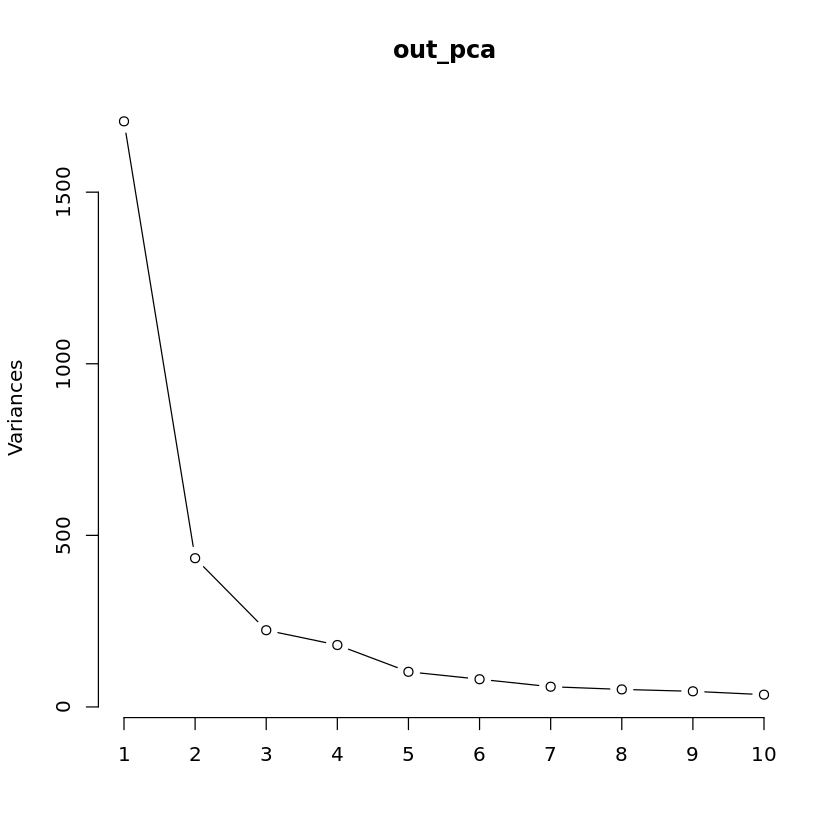

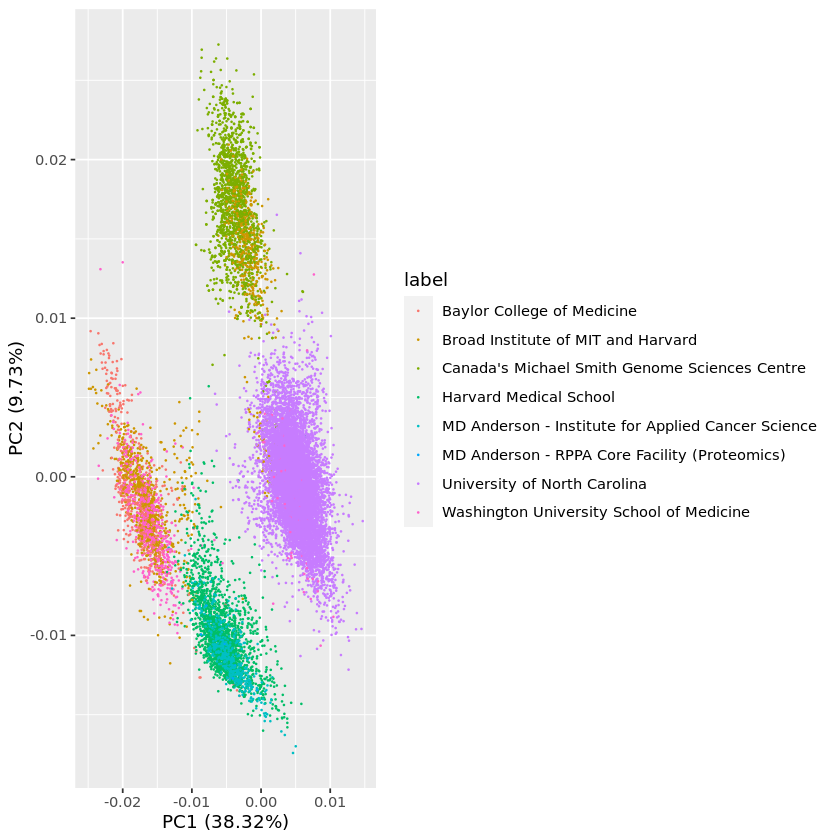

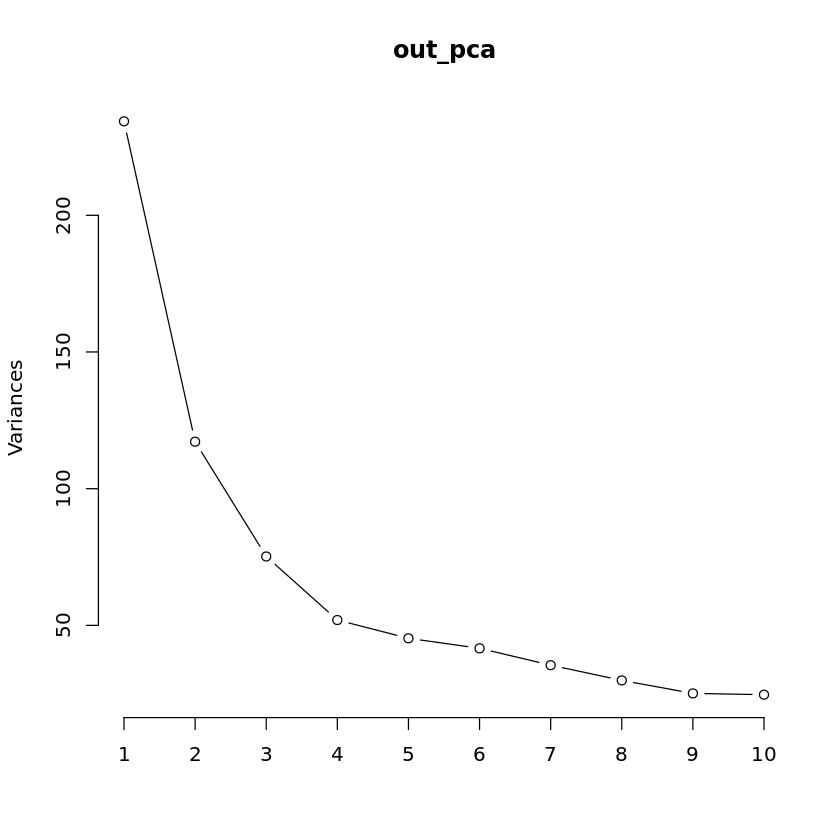

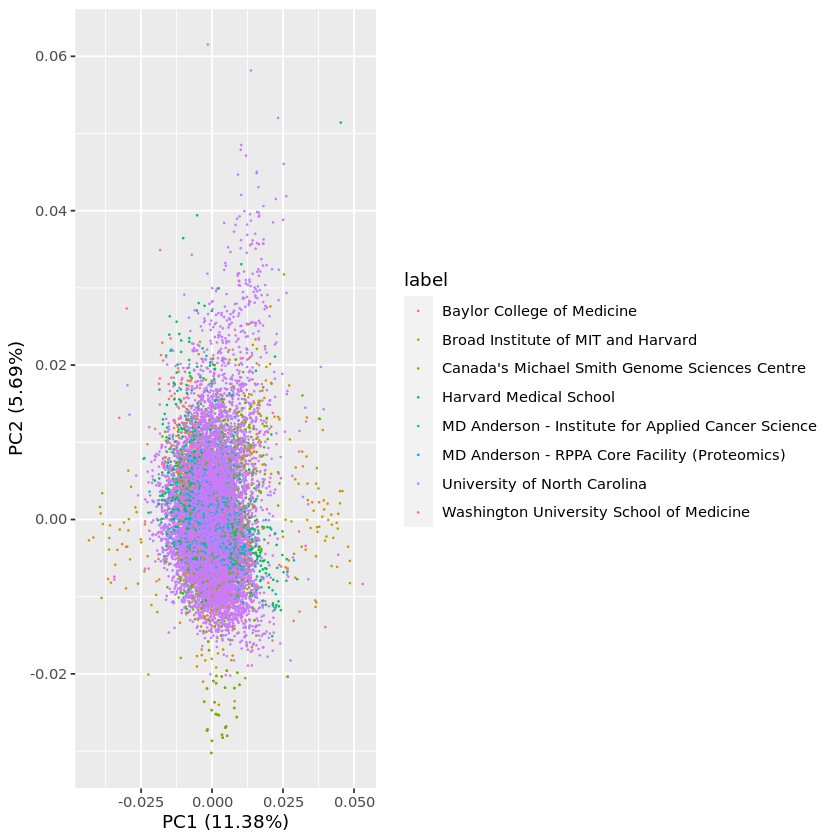

In [9]:
#convert to numeric and combine label
Rawdat<-as.data.frame(t(vdge$E))
QNordat<-as.data.frame(snmDataSampleTypeWithExpStrategyFA)

label<-metadataSamplesAllQC$data_submitting_center_label
Rawdat <- as.data.frame(cbind(label,Rawdat),stringsAsFactors = F)
QNordat <-as.data.frame(cbind(label,QNordat),stringsAsFactors = F)

#import data
QNordat[1:2,]
Rawdat[1:2,]

dim(snmDataSampleTypeWithExpStrategyFA)
dim(t(vdge$E))
dim(metadataSamplesAllQC)


#install.packages('ggfortify')
library(ggfortify)

#pca for raw data
# apply PCA - scale. = TRUE is highly advisable, but default is FALSE. 
out_pca <- prcomp(Rawdat[,-1])
#out_pca$x[,1]   #extract pca1
#write.csv(out_pca,file="data/pca.txt",quote=F,row.names=T)
plot(out_pca,type="l")
autoplot(prcomp(Rawdat[,-1]),data=Rawdat,colour='label',size=0.1,label=FALSE,label.size=3)

#pca for norm data
out_pca <- prcomp(QNordat[,-1])
#out_pca[2]
#write.csv(out_pca[2],file="data/pca_qnorm.txt",quote=F,row.names=T)
plot(out_pca,type="l")
#plot(out_pca$x[,1],out_pca$x[,2])
autoplot(prcomp(QNordat[,-1]),data=QNordat,colour='label',size=0.1,label=FALSE,label.size=3)

# PVCA using key filtered metadata features (i.e. narrowing down the extended version of this)

In [16]:
# Implement PVCA
# From extended model, remove variables that contribute very little if at all:
# ethnicity, gender, reference_genome

library(pvca)
pct_threshold <- 0.8
metaPVCAExtendedFiltered <- metadataSamplesAllQC[,c("sample_type",
                                            "disease_type",
                                            "data_submitting_center_label",
                                            "platform",
                                            "experimental_strategy", 
                                            "tissue_source_site_label",
                                            "portion_is_ffpe")]
print(dim(metaPVCAExtendedFiltered))
print(dim(snmDataSampleTypeWithExpStrategyFA))
print(dim(vbDataBarnDFReconciledQC))


par(mfcol=c(2,2))
pvcaVbRawNoVoomNoSNM_ExtendedFiltered_FA <- PVCA(counts = t(vbDataBarnDFReconciledQC), 
                                               meta = metaPVCAExtendedFiltered, 
                                               threshold = pct_threshold,
                                               inter = FALSE)
#save(pvcaVbRawNoVoomNoSNM_ExtendedFiltered_FA, file = "pvcaVbRawNoVoomNoSNM_ExtendedFiltered_FA.RData")
PlotPVCA(pvcaVbRawNoVoomNoSNM_ExtendedFiltered_FA, "Raw count data")

pvcaVoomNoSNM_ExtendedFiltered_FA <- PVCA(counts = vdge$E,
                                           meta = metaPVCAExtendedFiltered,
                                           threshold = pct_threshold,
                                           inter = FALSE)
#save(pvcaVoomNoSNM_ExtendedFiltered_FA, file = "pvcaVoomNoSNM_ExtendedFiltered_FA.RData")
PlotPVCA(pvcaVoomNoSNM_ExtendedFiltered_FA, "Voom Normalized")

pvcaSampleWithExpStrategySNM_ExtendedFiltered_FA <- PVCA(counts = t(snmDataSampleTypeWithExpStrategyFA), 
                                                       meta = metaPVCAExtendedFiltered,
                                                       threshold = pct_threshold,
                                                       inter = FALSE)
#save(pvcaSampleWithExpStrategySNM_ExtendedFiltered_FA, file = "pvcnoaSampleWithExpStrategySNM_ExtendedFiltered_FA.RData")
PlotPVCA(pvcaSampleWithExpStrategySNM_ExtendedFiltered_FA, 
         "Voom Normalized & SNM Corrected Plus Exp Strategy (Target is Sample Type)")

[1] 17625     7
[1] 17625  1795
[1] 17625  1993


ERROR: Error in PVCA(counts = t(vbDataBarnDFReconciledQC), meta = metaPVCAExtendedFiltered, : could not find function "PVCA"


# loocv model training 

normalizaton with age and gender

,specimen_id,diagnosis,disease_type,disease_type_consol,HvsC,host_age,host_age_ordered,host_age_binned,sex,tube_id,well_description,well_conc
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
12667.X3039009,not provided,not provided,healthy control,Control,Control,46,46,X4,female,HNN21,HNN21,0.205
12691.PC30,42899846,Prostate Cancer,Prostate Cancer,PRAD,Cancer,72,72,X7,male,PC30,PC30,0.121
12691.PC10,37286800,Prostate Cancer,Prostate Cancer,PRAD,Cancer,82,82,X8,male,PC10,PC10,0.367
12667.X2062971,not provided,not provided,healthy control,Control,Control,30,30,X2,male,HNL11,HNL11,0.243
12667.X2051123,not provided,not provided,healthy control,Control,Control,59,59,X5,female,HNL4,HNL4,0.199


,k__Archaea.p__Thaumarchaeota.o__Nitrosopumilales.f__Nitrosopumilaceae.g__Candidatus_Nitrosoarchaeum,k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Micrococcales.f__Dermabacteraceae.g__Helcobacillus,k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Actinomycetales.f__Actinomycetaceae.g__Arcanobacterium,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Alteromonadales.f__Alteromonadaceae.g__Aliagarivorans,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacteriales.f__Enterobacteriaceae.g__Escherichia,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Bibersteinia,k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Corynebacteriales.f__Dietziaceae.g__Dietzia,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacteriales.f__Enterobacteriaceae.g__Enterobacter,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacteriales.f__Enterobacteriaceae.g__Candidatus_Moranella,k__Bacteria.p__Bacteroidetes.c__Flavobacteriia.o__Flavobacteriales.f__Flavobacteriaceae.g__Vitellibacter,...,k__Viruses.f__Mimiviridae.g__Mimivirus,k__Viruses.f__Phycodnaviridae.g__Phaeovirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Skunalikevirus,k__Viruses.f__Parvoviridae.g__Tetraparvovirus,k__Viruses.o__Caudovirales.f__Myoviridae.g__Kayvirus,k__Viruses.o__Caudovirales.f__Podoviridae.g__Bcep22likevirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Tm4likevirus,k__Viruses.f__Poxviridae.g__Yatapoxvirus,k__Viruses.f__Anelloviridae.g__Alphatorquevirus,k__Viruses.f__Sphaerolipoviridae.g__Gammasphaerolipovirus
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
12667.X3039009,4,4,0,0,68,0,0,28,0,31,...,0,0,0,0,0,0,0,0,0,0
12691.PC30,12,0,0,5,31,0,0,22,0,9,...,6,0,0,0,0,0,0,0,7,0
12691.PC10,0,0,0,0,51,0,2,8,0,11,...,0,0,0,0,0,0,0,0,0,0
12667.X2062971,0,1,0,0,23,2,2,5,0,5,...,0,0,0,0,0,0,0,0,0,0
12667.X2051123,0,0,0,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Loaded gbm 2.1.5



[1] TRUE

,k__Archaea.p__Thaumarchaeota.o__Nitrosopumilales.f__Nitrosopumilaceae.g__Candidatus_Nitrosoarchaeum,k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Micrococcales.f__Dermabacteraceae.g__Helcobacillus,k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Actinomycetales.f__Actinomycetaceae.g__Arcanobacterium,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Alteromonadales.f__Alteromonadaceae.g__Aliagarivorans,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacteriales.f__Enterobacteriaceae.g__Escherichia,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Bibersteinia,k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Corynebacteriales.f__Dietziaceae.g__Dietzia,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacteriales.f__Enterobacteriaceae.g__Enterobacter,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacteriales.f__Enterobacteriaceae.g__Candidatus_Moranella,k__Bacteria.p__Bacteroidetes.c__Flavobacteriia.o__Flavobacteriales.f__Flavobacteriaceae.g__Vitellibacter,...,k__Viruses.f__Mimiviridae.g__Mimivirus,k__Viruses.f__Phycodnaviridae.g__Phaeovirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Skunalikevirus,k__Viruses.f__Parvoviridae.g__Tetraparvovirus,k__Viruses.o__Caudovirales.f__Myoviridae.g__Kayvirus,k__Viruses.o__Caudovirales.f__Podoviridae.g__Bcep22likevirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Tm4likevirus,k__Viruses.f__Poxviridae.g__Yatapoxvirus,k__Viruses.f__Anelloviridae.g__Alphatorquevirus,k__Viruses.f__Sphaerolipoviridae.g__Gammasphaerolipovirus
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12667.X3039009,7.246565,6.938824,5.187512,5.143844,10.424536,5.356320,5.650819,9.418843,5.175996,9.069258,...,5.012192,5.207400,5.155473,5.170596,5.207424,5.332123,5.099636,5.155852,4.849753,5.277023
12691.PC30,9.307107,4.956153,5.279706,7.125356,9.501012,5.130560,5.880991,9.023874,5.209506,7.478062,...,7.374658,5.283447,5.305703,5.170617,5.298929,5.464818,5.059170,5.147460,7.499703,5.344538
12691.PC10,5.656255,4.929795,5.283182,4.819280,11.467247,5.170733,8.521350,9.015381,5.210478,9.155838,...,4.765581,5.291247,5.302213,5.170415,5.306734,5.499731,5.043543,5.144053,4.568392,5.367472
12667.X2062971,5.445431,6.294962,5.265108,4.850570,10.645505,6.958716,7.440257,8.027863,5.205423,8.281999,...,4.945695,5.250691,5.320358,5.171464,5.266150,5.318184,5.124807,5.161769,4.932133,5.248212
12667.X2051123,5.434913,5.040201,5.216217,5.160208,11.427023,5.432731,5.810458,5.281194,5.201446,4.482105,...,4.991350,5.241726,5.175123,5.194520,5.241756,5.401696,5.103506,5.175609,4.783004,5.331025


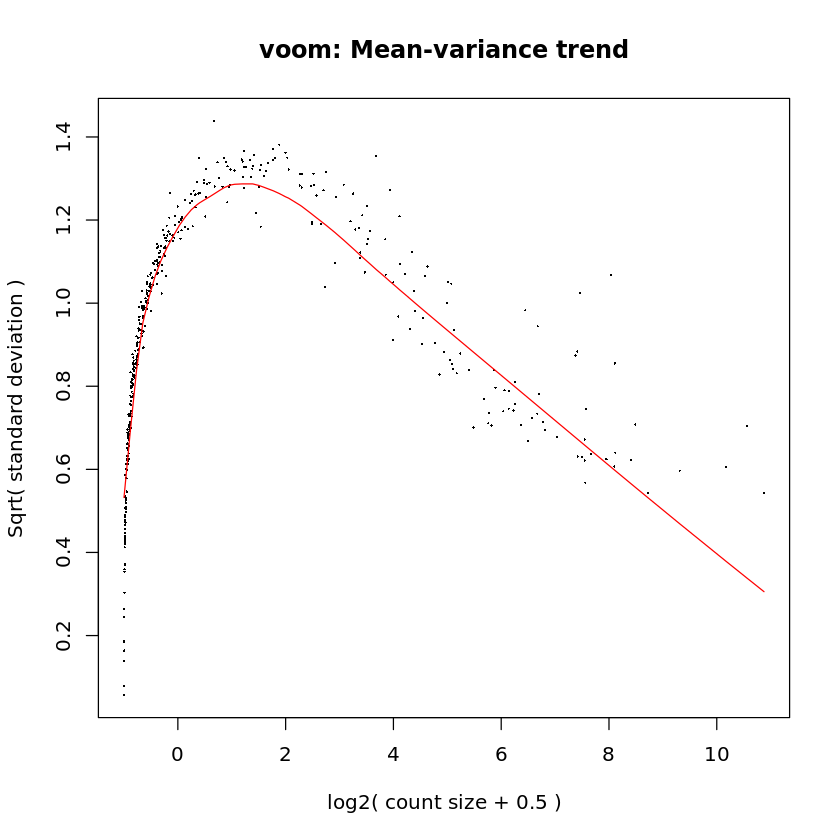

In [10]:
#read in data
qcMetadata <- as.data.frame(read.csv("data/Metadata-Plasma-Filtered-For-Analysis.csv", header = TRUE, sep = ",", dec = ".",stringsAsFactors=FALSE))
row.names(qcMetadata) <- qcMetadata[,1]
qcMetadata<-qcMetadata[,-1]
qcMetadata[1:5,]

qcData <- as.data.frame(read.csv("data/Kraken-Plasma-Validation-Raw-Data-cfDNA.csv", header = TRUE, sep = ",", dec = ".",stringsAsFactors=FALSE))
row.names(qcData) <- qcData[,1]
qcData<-qcData[,-1]
qcData[1:5,]

## Load packages ##
  library(limma)
  library(edgeR)
  library(dplyr)
  library(snm)
  library(doMC)
  library(tibble)
  library(gbm)
  
  numCores <- detectCores()
  registerDoMC(cores=numCores)
  
  # Set up design matrix
  covDesignNorm <- model.matrix(~0 + disease_type_consol +
                                    host_age + # host_age should be numeric
                                    sex, # sex should be a factor
                                  data = qcMetadata)
  
  # Check row dimensions
  dim(covDesignNorm)[1] == dim(qcData)[1]
  
  #print(colnames(covDesignNorm))
  # The following corrects for column names that are incompatible with downstream processing
  colnames(covDesignNorm) <- gsub('([[:punct:]])|\\s+','',colnames(covDesignNorm))
  #print(colnames(covDesignNorm))
  
  # Set up counts matrix
  counts <- t(qcData) # DGEList object from a table of counts (rows=features, columns=samples)
  
  # Quantile normalize and plug into voom
  dge <- DGEList(counts = counts)
  vdge <- voom(dge, design = covDesignNorm, plot = TRUE, save.plot = TRUE, 
                                              normalize.method="quantile")
  
  # List biological and normalization variables in model matrices
  bio.var <- model.matrix(~disease_type_consol,
                          data=qcMetadata)
  
  adj.var <- model.matrix(~host_age + sex,
                          data=qcMetadata)
  
  colnames(bio.var) <- gsub('([[:punct:]])|\\s+','',colnames(bio.var))
  colnames(adj.var) <- gsub('([[:punct:]])|\\s+','',colnames(adj.var))
  #print(dim(adj.var))
  #print(dim(bio.var))
  #print(dim(t(vdge$E)))
  #print(dim(covDesignNorm))
  
  snmDataObjOnly <- snm(raw.dat = vdge$E, 
                        bio.var = bio.var, 
                        adj.var = adj.var, 
                        rm.adj=TRUE,
                        verbose = TRUE,
                        diagnose = TRUE)
  snmData <- as.data.frame(t(snmDataObjOnly$norm.dat))
  snmData[1:5,]

model training

In [14]:
# Load dependencies
require(devtools)
require(doMC)
require(tibble)
require(gbm)
require(splitstackshape)
require(reshape2)
require(ggpubr)
require(caret) # for model building
require(pROC) # for AUC calculations
require(purrr) # for functional programming using map()
require(dplyr) # for data manipulation
require(doMC) # for parallel computing
require(gbm) # for machine learning
require(tibble) # for df operations
require(cowplot) # for plotting
require(PRROC) # for precision-recall curves
require(MLmetrics) # for multi-class learning
require(caret) # for machine learning
require(e1071)

defaultGBMGrid <-  expand.grid(interaction.depth = seq(1,3),
                               n.trees = floor((1:3) * 50),
                               shrinkage = 0.1,
                               n.minobsinnode = 5)
customGBMGrid <-  expand.grid(interaction.depth = seq(1,3),
                              n.trees = floor((1:3) * 50),
                              shrinkage = 0.1,
                              n.minobsinnode = 1)
numKFold <- 4
numResampleIter <- 1
metadataPSMatchedDPQCFiltered<- qcMetadata

ml2DTs <- function(snmData, 
                   classOfInterest = "Lung Adenocarcinoma", 
                   cutPoint = 0.5, 
                   samplingSize = 20, 
                   caretTuneGrid = defaultGBMGrid){
  
  metaTmp1 <- droplevels(metadataPSMatchedDPQCFiltered[(metadataPSMatchedDPQCFiltered$disease_type_consol %in% c("PRAD",
                                                                                                             "SKCM",
                                                                                                             "NSCLC")),])
  tmp <- metaTmp1
  tmp$disease_type_consol <- factor(ifelse(metaTmp1$disease_type_consol == classOfInterest, yes = classOfInterest, no = "Other"))
  metadataSimSampled <- as.data.frame(stratified(tmp,
                                                 group = "disease_type_consol",
                                                 size = samplingSize,
                                                 keep.rownames = TRUE,
                                                 replace = FALSE,
                                                 bothSets = FALSE))
  rownames(metadataSimSampled) <- metadataSimSampled$rn
  mlDataY <- metadataSimSampled
  mlDataX <- snmData[rownames(mlDataY),]
  
  set.seed(42)
  index <- createDataPartition(mlDataY$disease_type_consol, p = 0.7, list = FALSE)
  trainX <- mlDataX[index,]
  trainY <- mlDataY[index,]$disease_type_consol
  testX <- mlDataX[-index,]
  testY <- mlDataY[-index,]$disease_type_consol
  # print(testY)
  
  refactoredTrainY <- factor(gsub('([[:punct:]])|\\s+','',trainY))
  refactoredTestY <- factor(gsub('([[:punct:]])|\\s+','',testY))
  
  set.seed(42)
  ctrl <- trainControl(method = "repeatedcv",
                       number = numKFold,
                       repeats = numResampleIter,
                       sampling = "up",
                       summaryFunction = twoClassSummary,
                       classProbs = TRUE,
                       verboseIter = TRUE,
                       savePredictions = TRUE,
                       allowParallel=TRUE)
  
  mlModel <- train(x = trainX,
                   y = refactoredTrainY,
                   method = "gbm",
                   preProcess = c("scale","center"),
                   trControl = ctrl,
                   verbose = TRUE,
                   metric = "ROC",
                   tuneGrid = customGBMGrid)
  
  positiveClass <- gsub(" ","", classOfInterest)
  negativeClass <- "Other"
  
  predProbs <- as.numeric(predict(mlModel, newdata = testX, type = "prob")[,positiveClass])
  fg <- predProbs[refactoredTestY == positiveClass]
  bg <- predProbs[refactoredTestY == negativeClass]
  
  prroc_roc <- roc.curve(scores.class0 = fg, scores.class1 = bg, curve = T)
  prroc_pr <- pr.curve(scores.class0 = fg, scores.class1 = bg, curve = T, rand.compute=T)
  
  # par(mfrow = c(1,2))
  plot(prroc_roc)
  plot(prroc_pr)
  # dev.off()
  
  
  predClass <- predict(mlModel, newdata = testX)
  
  confusionMatrix(table(predict(mlModel, newdata = testX, type="prob")[,positiveClass] >= cutPoint,
                        refactoredTestY == positiveClass))
}

#-----------------------------------------#
# Machine learning
#-----------------------------------------#


# mlHvsC <- function(snmData){
# Load dependencies


mlHvsC <- function(snmData){
  
  numCores <- detectCores()
  registerDoMC(cores=numCores)
  
  defaultGBMGrid <-  expand.grid(interaction.depth = seq(1,3),
                                 n.trees = floor((1:3) * 50),
                                 shrinkage = 0.1,
                                 n.minobsinnode = 5)
  customGBMGrid <-  expand.grid(interaction.depth = seq(1,3),
                                n.trees = floor((1:3) * 50),
                                shrinkage = 0.1,
                                n.minobsinnode = 1)
  
  caretTuneGrid <- defaultGBMGrid
  numKFold <- 4
  numResampleIter <- 1
  
  mlDataY <- metadataPSMatchedDPQCFiltered
  mlDataX <- snmData[rownames(mlDataY),]
  
  set.seed(42)
  index <- createDataPartition(mlDataY$HvsC, p = 0.7, list = FALSE)
  trainX <- mlDataX[index,]
  trainY <- mlDataY[index,]$HvsC
  testX <- mlDataX[-index,]
  testY <- mlDataY[-index,]$HvsC
  # print(testY)
  
  refactoredTrainY <- factor(gsub('([[:punct:]])|\\s+','',trainY))
  refactoredTestY <- factor(gsub('([[:punct:]])|\\s+','',testY))
  
  set.seed(42)
  ctrl <- trainControl(method = "repeatedcv",
                       number = numKFold,
                       repeats = numResampleIter,
                       sampling = "up",
                       summaryFunction = twoClassSummary,
                       classProbs = TRUE,
                       verboseIter = TRUE,
                       savePredictions = TRUE,
                       allowParallel=TRUE)
  
  mlModel <- train(x = trainX,
                   y = refactoredTrainY,
                   method = "gbm",
                   preProcess = c("scale","center"),
                   trControl = ctrl,
                   verbose = TRUE,
                   metric = "ROC",
                   tuneGrid = defaultGBMGrid)
  
  positiveClass <- "Cancer"
  negativeClass <- "Control"
  predProbs <- as.numeric(predict(mlModel, newdata = testX, type = "prob")[,positiveClass])
  fg <- predProbs[refactoredTestY == positiveClass]
  bg <- predProbs[refactoredTestY == negativeClass]
  
  prroc_roc <- roc.curve(scores.class0 = fg, scores.class1 = bg, curve = T)
  prroc_pr <- pr.curve(scores.class0 = fg, scores.class1 = bg, curve = T, rand.compute=T)
  
  plot(prroc_roc)
  plot(prroc_pr)
  
  predClass <- predict(mlModel, newdata = testX)
  print(confusionMatrix(data = predClass, reference = refactoredTestY, positive = positiveClass))
}

#-----------------------------------------------------

loocvDTs <- function(snmData, samplingSize = 15, DTs, caretTuneGrid = defaultGBMGrid,
                     filenameString = paste(DTs,collapse = "__"), HvsCFlag = FALSE){
  
  if(HvsCFlag){
    metaTmpX <- droplevels(metadataPSMatchedDPQCFiltered[(metadataPSMatchedDPQCFiltered$disease_type_consol %in% DTs),])
    metaTmpX$disease_type_consol <- metaTmpX$HvsC
    classes <- gsub(" ","",levels(metaTmpX$disease_type_consol))
  } else{
    metaTmpX <- droplevels(metadataPSMatchedDPQCFiltered[(metadataPSMatchedDPQCFiltered$disease_type_consol %in% DTs),])
    classes <- gsub(" ","",DTs)
  }
  
  # Do LOOCV model building and testing
  
  multiClassSummaryStats <- list()
  multiClassSummaryStatsDist <- list()
  numKFold <- 4
  numResampleIter <- 1
  metaData <- metaTmpX
  snmData <- snmData # dataPSUniqueDecontamQC # 
  iterSize <- 1
  for(jj in 1:iterSize){
    metadataSimSampled <- as.data.frame(stratified(metaData,
                                                   group = "disease_type_consol",
                                                   size = samplingSize,
                                                   keep.rownames = TRUE,
                                                   replace = FALSE,
                                                   bothSets = FALSE))
    rownames(metadataSimSampled) <- metadataSimSampled$rn
    mlDataY <- metadataSimSampled
    mlDataX <- snmData[rownames(mlDataY),]
    dim(mlDataY)[1] == dim(mlDataX)[1] # Sanity check
    
    # Create data partitions
    # set.seed(42)
    indexSuper <- 1:dim(mlDataY)[1]
    predProbs <- list()
    obsClass <- vector()
    predClass <- vector()
    varImpBestModelDF2OrderedNonzeroList <- list()
    
    for(ii in 1:length(indexSuper)){
      print(sprintf("Iteration: %d/%d", ii, length(indexSuper)))
      index <- indexSuper[ii]
      # print(index)
      trainX <- mlDataX[-index,]
      trainY <- mlDataY[-index,]$disease_type_consol
      testX <- mlDataX[index,,drop=FALSE]
      testY <- mlDataY[index,,drop=FALSE]$disease_type_consol
      # print(testY)
      
      refactoredTrainY <- factor(gsub('([[:punct:]])|\\s+','',trainY))
      refactoredTestY <- factor(gsub('([[:punct:]])|\\s+','',testY))
      
      obsClass[ii] <- as.character(refactoredTestY)
      
      set.seed(42)
      ctrl <- trainControl(method = "repeatedcv",
                           number = numKFold,
                           repeats = numResampleIter,
                           sampling = "up",
                           summaryFunction = multiClassSummary,
                           classProbs = TRUE,
                           verboseIter = FALSE,
                           savePredictions = TRUE,
                           allowParallel=TRUE)
      
      mlModel <- train(x = trainX,
                       y = refactoredTrainY,
                       method = "gbm",
                       preProcess = c("scale","center"),
                       trControl = ctrl,
                       verbose = FALSE,
                       metric = "ROC",
                       tuneGrid = caretTuneGrid)
      
      predProbs[ii] <- list(predict(mlModel, newdata = testX, type = "prob"))
      predClass[ii] <- as.character(predict(mlModel, newdata = testX, type = "raw"))
      
      varImpBestModelDF <- as.data.frame(varImp( mlModel$finalModel, scale = FALSE ))
      varImpBestModelDF2 <- rownames_to_column(varImpBestModelDF, "Taxa")
      varImpBestModelDF2Ordered <- varImpBestModelDF2[order(-varImpBestModelDF2$Overall),]
      colnames(varImpBestModelDF2Ordered)[2] <- "varImp"
      varImpBestModelDF2OrderedNonzero <- varImpBestModelDF2Ordered[varImpBestModelDF2Ordered$varImp != 0,]
      varImpBestModelDF2OrderedNonzeroList[[ii]] <- varImpBestModelDF2OrderedNonzero
      
      rm(mlModel)
    }
    
    loocvPreds <- cbind(obs = factor(obsClass,
                                     levels = classes),
                        pred = factor(predClass,
                                      levels = classes),
                        do.call(rbind,predProbs))
    # multiClassSummaryStats <- multiClassSummary(loocvPreds, lev = classes)
    # print(multiClassSummaryStats)
    
    multiClassSummaryStats[[jj]] <- multiClassSummary(loocvPreds, lev = classes)
    print(multiClassSummaryStats[[jj]])
    
    filenameROC <- paste0(filenameString,"__ROC.png")
    filenamePR <- paste0(filenameString,"__PR.png")
    filenameROCData <- paste0(filenameString,"__Data__ROC.csv")
    filenamePRData <- paste0(filenameString,"__Data__PR.csv")
    filenameSink <- paste0(filenameString,"__CM.txt")
    
    predProbs <- loocvPreds[,DTs[1]]
    fg <- predProbs[loocvPreds$obs == DTs[1]]
    bg <- predProbs[loocvPreds$obs == DTs[2]]
    
    prroc_roc <- roc.curve(scores.class0 = fg, scores.class1 = bg, curve = T)
    prroc_pr <- pr.curve(scores.class0 = fg, scores.class1 = bg, curve = T, rand.compute=T)
    
    png(filename=filenameROC, width = 6, height = 4, units = 'in', res = 300)
    plot(prroc_roc)
    dev.off()
    
    png(filename=filenamePR, width = 6, height = 4, units = 'in', res = 300)
    plot(prroc_pr)
    dev.off()
    
    rocCurveData <- cbind(as.data.frame(prroc_roc$curve), DT1 = DTs[1], DT2 = DTs[2])
    prCurveData <- cbind(as.data.frame(prroc_pr$curve), DT1 = DTs[1], DT2 = DTs[2])
    
    write.table(prCurveData, sep=",", file = filenamePRData, col.names = FALSE)
    write.table(rocCurveData, sep=",", file = filenameROCData, col.names = FALSE)
  }
  
  print(confusionMatrix(loocvPreds$obs, loocvPreds$pred))
  multiClassSummaryStatsDist <- data.frame(do.call(rbind, multiClassSummaryStats))
  
  sink(filenameSink)
  print(print(confusionMatrix(loocvPreds$obs, loocvPreds$pred)))
  sink()
}

#-----------------------------------------------------

ml2DTs <- function(snmData, 
                   classOfInterest = "Lung Adenocarcinoma", 
                   cutPoint = 0.5, 
                   samplingSize = 20, 
                   caretTuneGrid = defaultGBMGrid){
  
  metaTmp1 <- droplevels(metadataPSMatchedDPQCFiltered[(metadataPSMatchedDPQCFiltered$disease_type_consol %in% c("PRAD",
                                                                                                             "SKCM",
                                                                                                             "NSCLC")),])
  tmp <- metaTmp1
  tmp$disease_type_consol <- factor(ifelse(metaTmp1$disease_type_consol == classOfInterest, yes = classOfInterest, no = "Other"))
  metadataSimSampled <- as.data.frame(stratified(tmp,
                                                 group = "disease_type_consol",
                                                 size = samplingSize,
                                                 keep.rownames = TRUE,
                                                 replace = FALSE,
                                                 bothSets = FALSE))
  rownames(metadataSimSampled) <- metadataSimSampled$rn
  mlDataY <- metadataSimSampled
  mlDataX <- snmData[rownames(mlDataY),]
  
  set.seed(42)
  index <- createDataPartition(mlDataY$disease_type_consol, p = 0.7, list = FALSE)
  trainX <- mlDataX[index,]
  trainY <- mlDataY[index,]$disease_type_consol
  testX <- mlDataX[-index,]
  testY <- mlDataY[-index,]$disease_type_consol
  # print(testY)
  
  refactoredTrainY <- factor(gsub('([[:punct:]])|\\s+','',trainY))
  refactoredTestY <- factor(gsub('([[:punct:]])|\\s+','',testY))
  
  set.seed(42)
  ctrl <- trainControl(method = "repeatedcv",
                       number = numKFold,
                       repeats = numResampleIter,
                       sampling = "up",
                       summaryFunction = twoClassSummary,
                       classProbs = TRUE,
                       verboseIter = TRUE,
                       savePredictions = TRUE,
                       allowParallel=TRUE)
  
  mlModel <- train(x = trainX,
                   y = refactoredTrainY,
                   method = "gbm",
                   preProcess = c("scale","center"),
                   trControl = ctrl,
                   verbose = TRUE,
                   metric = "ROC",
                   tuneGrid = customGBMGrid)
  
  positiveClass <- gsub(" ","", classOfInterest)
  negativeClass <- "Other"
  
  predProbs <- as.numeric(predict(mlModel, newdata = testX, type = "prob")[,positiveClass])
  fg <- predProbs[refactoredTestY == positiveClass]
  bg <- predProbs[refactoredTestY == negativeClass]
  
  prroc_roc <- roc.curve(scores.class0 = fg, scores.class1 = bg, curve = T)
  prroc_pr <- pr.curve(scores.class0 = fg, scores.class1 = bg, curve = T, rand.compute=T)
  
  # par(mfrow = c(1,2))
  plot(prroc_roc)
  plot(prroc_pr)
  # dev.off()
  
  
  predClass <- predict(mlModel, newdata = testX)
  
  confusionMatrix(table(predict(mlModel, newdata = testX, type="prob")[,positiveClass] >= cutPoint,
                        refactoredTestY == positiveClass))
}

In [17]:
snmDataKrakenCFDecontamDPQC<-snmData
hVsC4 <- loocvDTs(snmData = snmDataKrakenCFDecontamDPQC,
                 samplingSize = 100, 
                 DTs = c("Control","SKCM", "PRAD", "NSCLC"),
                 caretTuneGrid = defaultGBMGrid, HvsCFlag = TRUE)

Groups Control contain fewer rows than requested. Returning all rows.



[1] "Iteration: 1/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 2/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 3/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 4/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 5/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 6/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 7/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 8/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 9/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 10/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 11/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 12/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 13/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 14/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 15/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 16/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 17/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 18/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 19/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 20/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 21/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 22/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 23/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 24/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 25/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 26/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 27/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 28/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 29/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 30/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 31/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 32/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 33/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 34/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 35/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 36/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 37/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 38/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 39/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 40/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 41/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 42/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 43/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 44/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 45/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 46/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 47/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 48/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 49/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 50/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 51/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 52/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 53/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 54/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 55/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 56/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 57/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 58/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 59/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 60/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 61/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 62/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 63/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 64/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 65/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 66/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 67/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 68/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 69/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 70/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 71/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 72/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 73/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 74/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 75/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 76/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 77/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 78/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 79/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 80/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 81/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 82/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 83/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 84/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 85/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 86/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 87/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 88/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 89/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 90/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 91/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 92/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 93/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 94/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 95/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 96/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 97/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 98/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 99/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 100/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 101/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 102/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 103/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 104/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 105/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 106/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 107/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 108/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 109/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 110/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 111/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 112/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 113/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 114/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 115/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 116/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 117/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 118/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 119/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 120/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 121/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 122/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 123/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 124/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 125/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 126/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 127/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 128/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 129/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 130/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 131/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 132/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 133/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 134/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 135/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 136/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 137/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 138/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 139/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 140/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 141/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 142/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 143/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 144/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 145/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 146/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 147/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 148/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 149/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 150/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 151/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 152/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 153/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 154/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 155/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 156/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 157/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 158/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 159/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 160/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 161/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 162/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 163/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 164/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 165/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 166/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 167/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 168/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 169/169"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


ERROR: Error in colMeans(prob_stats, na.rm = TRUE): 'x' must be an array of at least two dimensions


In [49]:
hVsC_NSCLC <- loocvDTs(snmData = snmDataKrakenCFDecontamDPQC,
                 samplingSize = 69, 
                 DTs = c("NSCLC","Control"),
                 caretTuneGrid = defaultGBMGrid)

Groups NSCLC contain fewer rows than requested. Returning all rows.



[1] "Iteration: 1/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 2/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 3/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 4/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 5/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 6/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 7/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 8/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 9/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 10/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 11/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 12/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 13/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 14/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 15/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 16/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 17/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 18/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 19/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 20/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 21/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 22/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 23/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 24/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 25/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 26/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 27/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 28/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 29/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 30/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 31/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 32/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 33/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 34/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 35/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 36/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 37/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 38/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 39/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 40/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 41/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 42/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 43/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 44/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 45/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 46/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 47/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 48/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 49/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 50/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 51/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 52/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 53/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 54/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 55/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 56/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 57/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 58/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 59/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 60/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 61/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 62/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 63/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 64/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 65/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 66/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 67/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 68/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 69/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 70/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 71/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 72/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 73/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 74/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 75/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 76/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 77/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 78/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 79/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 80/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 81/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 82/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 83/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 84/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 85/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 86/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 87/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 88/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 89/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 90/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 91/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 92/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 93/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 94/94"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


          logLoss               AUC             prAUC          Accuracy 
        0.2182512         0.9710145         0.9346630         0.9042553 
            Kappa                F1       Sensitivity       Specificity 
        0.7638191         0.8301887         0.8800000         0.9130435 
   Pos_Pred_Value    Neg_Pred_Value         Precision            Recall 
        0.7857143         0.9545455         0.7857143         0.8800000 
   Detection_Rate Balanced_Accuracy 
        0.2340426         0.8965217 
Confusion Matrix and Statistics

          Reference
Prediction NSCLC Control
   NSCLC      22       3
   Control     6      63
                                         
               Accuracy : 0.9043         
                 95% CI : (0.826, 0.9553)
    No Information Rate : 0.7021         
    P-Value [Acc > NIR] : 2.272e-06      
                                         
                  Kappa : 0.7638         
                                         
 Mcnemar's Test P-Value 

In [50]:
prad_nsclc <- loocvDTs(snmData = snmDataKrakenCFDecontamDPQC,
                 samplingSize = 59, 
                 DTs = c("PRAD","NSCLC"),
                 caretTuneGrid = defaultGBMGrid)

Groups NSCLC contain fewer rows than requested. Returning all rows.



[1] "Iteration: 1/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 2/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 3/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 4/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 5/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 6/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 7/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 8/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 9/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 10/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 11/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 12/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 13/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 14/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 15/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 16/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 17/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 18/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 19/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 20/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 21/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 22/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 23/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 24/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 25/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 26/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 27/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 28/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 29/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 30/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 31/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 32/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 33/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 34/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 35/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 36/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 37/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 38/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 39/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 40/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 41/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 42/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 43/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 44/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 45/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 46/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 47/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 48/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 49/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 50/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 51/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 52/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 53/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 54/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 55/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 56/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 57/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 58/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 59/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 60/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 61/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 62/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 63/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 64/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 65/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 66/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 67/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 68/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 69/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 70/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 71/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 72/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 73/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 74/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 75/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 76/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 77/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 78/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 79/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 80/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 81/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 82/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 83/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 84/84"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


          logLoss               AUC             prAUC          Accuracy 
        0.3545810         0.8854237         0.8589545         0.8690476 
            Kappa                F1       Sensitivity       Specificity 
        0.6755618         0.9090909         0.9322034         0.7200000 
   Pos_Pred_Value    Neg_Pred_Value         Precision            Recall 
        0.8870968         0.8181818         0.8870968         0.9322034 
   Detection_Rate Balanced_Accuracy 
        0.6547619         0.8261017 
Confusion Matrix and Statistics

          Reference
Prediction PRAD NSCLC
     PRAD    55     4
     NSCLC    7    18
                                          
               Accuracy : 0.869           
                 95% CI : (0.7778, 0.9328)
    No Information Rate : 0.7381          
    P-Value [Acc > NIR] : 0.00287         
                                          
                  Kappa : 0.6756          
                                          
 Mcnemar's Test P-Value :

In [18]:
DT3 <- loocvDTs(snmData = snmDataKrakenCFDecontamDPQC,
                 samplingSize = 59, 
                 DTs = c("PRAD","NSCLC","SKCM"),
                 caretTuneGrid = defaultGBMGrid)

Groups SKCM, NSCLC contain fewer rows than requested. Returning all rows.



[1] "Iteration: 1/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 2/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 3/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 4/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 5/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 6/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 7/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 8/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 9/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 10/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 11/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 12/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 13/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 14/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 15/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 16/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 17/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 18/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 19/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 20/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 21/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 22/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 23/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 24/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 25/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 26/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 27/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 28/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 29/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 30/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 31/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 32/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 33/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 34/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 35/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 36/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 37/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 38/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 39/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 40/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 41/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 42/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 43/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 44/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 45/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 46/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 47/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 48/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 49/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 50/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 51/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 52/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 53/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 54/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 55/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 56/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 57/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 58/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 59/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 60/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 61/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 62/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 63/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 64/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 65/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 66/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 67/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 68/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 69/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 70/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 71/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 72/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 73/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 74/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 75/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 76/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 77/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 78/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 79/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 80/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 81/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 82/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 83/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 84/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 85/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 86/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 87/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 88/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 89/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 90/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 91/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 92/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


[1] "Iteration: 93/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 94/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 95/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 96/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 97/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 98/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 99/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Iteration: 100/100"


Warning message in train.default(x = trainX, y = refactoredTrainY, method = "gbm", :
“The metric "ROC" was not in the result set. logLoss will be used instead.”


               logLoss                    AUC                  prAUC 
             0.6684274              0.8397166              0.6781436 
              Accuracy                  Kappa                Mean_F1 
             0.7200000              0.4981179              0.6552332 
      Mean_Sensitivity       Mean_Specificity    Mean_Pos_Pred_Value 
             0.6511864              0.8319280              0.6615821 
   Mean_Neg_Pred_Value         Mean_Precision            Mean_Recall 
             0.8353929              0.6615821              0.6511864 
   Mean_Detection_Rate Mean_Balanced_Accuracy 
             0.2400000              0.7415572 
Confusion Matrix and Statistics

          Reference
Prediction PRAD NSCLC SKCM
     PRAD    48     3    8
     NSCLC    8    16    1
     SKCM     5     3    8

Overall Statistics
                                          
               Accuracy : 0.72            
                 95% CI : (0.6213, 0.8052)
    No Information Rate : 0.61      